In [3]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [4]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(seen_df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

(2312, 242)


In [5]:
from alterations import postfix_data
df = postfix_data(df)

In [6]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2312, 20000)

In [5]:
broad_cats = [x for x in df.columns if "12 - " in x and "Physical systems" not in x and "prediction" not in x]
broad_cats

['12 - Coastal and marine Ecosystems',
 '12 - Human and managed',
 '12 - Mountains, snow and ice',
 '12 - Rivers, lakes, and soil moisture',
 '12 - Terrestrial ES']

In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[broad_cats])
print(y.shape)

multimodels = [
    {
       'title': 'One vs rest SVC balanced rbf', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
    },  
    {
       'title': 'One vs rest SVC balanced rbf C10', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced", C=10))
    },
    {
        'title': 'One vs rest SVC balanced C10', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
    },   
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },  
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, rel_index, n_splits=10, classes=broad_cats, df = df)


(2544, 5)
1
2
3
4
5
6
7
8
9
10


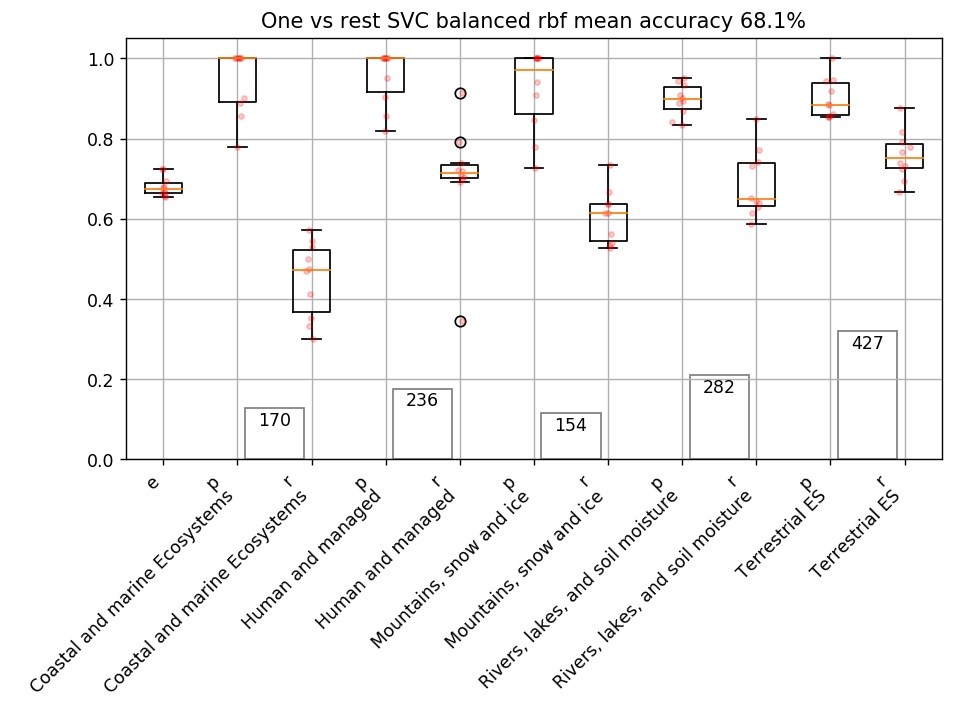

In [7]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

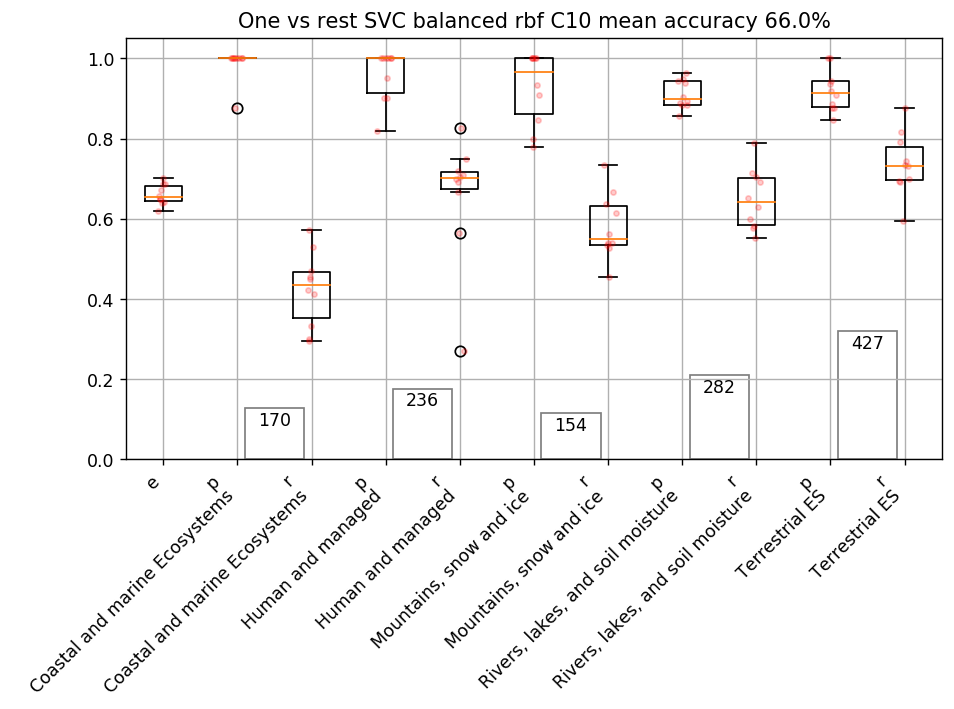

In [8]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[1]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

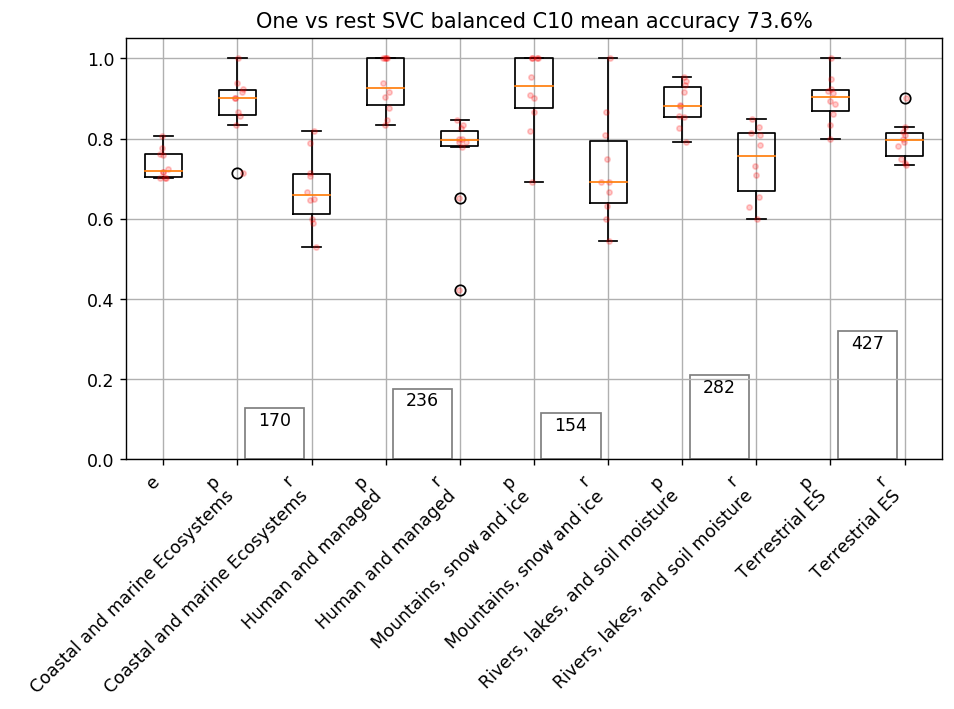

In [9]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[2]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

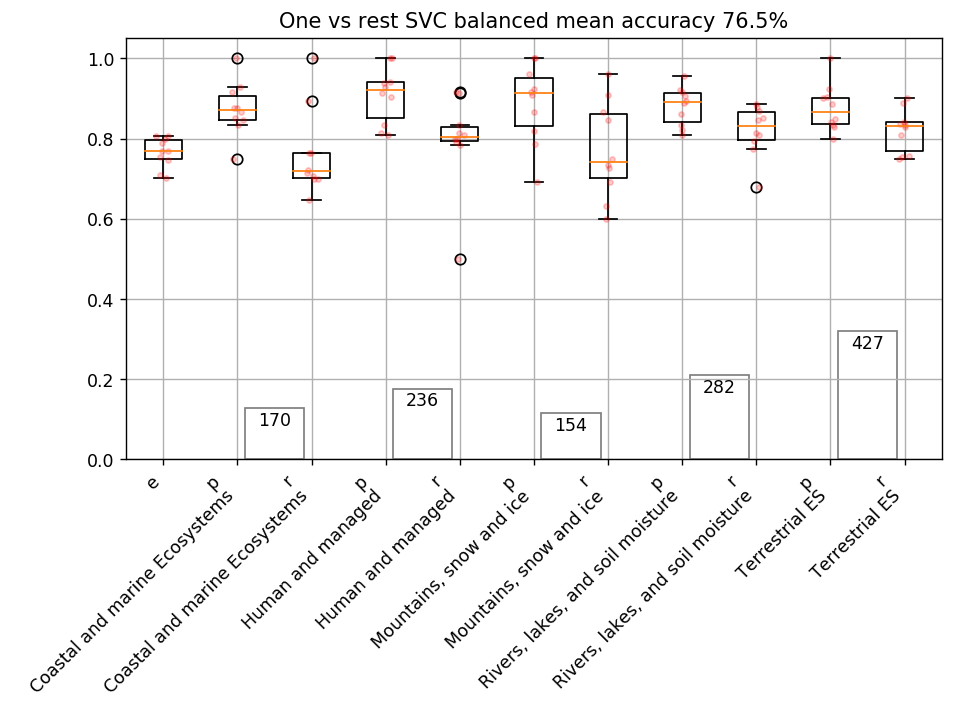

In [10]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[3]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [11]:
# 73.7 72.2 68.9 66.4

In [12]:
c = "12 - Coastal and marine Ecosystems"
cp = c +" - k_prediction"
fpfn = df[
    (df[cp]>0.5) & 
    (df[c]==0)
]
for i, row in fpfn.sort_values(cp,ascending=False).reset_index(drop=True).iterrows():
    print("\n####\n")
    print(row['title'])
    print(row["content"])
    print(row[cp])
    print(row[c])
    d = Doc.objects.get(pk=row['id'])
    
    dcs = Category.objects.filter(docusercat__doc=d, level__in=[4,6,12])
    if not dcs.exists():
        dcs = Category.objects.filter(docusercat__doc=d)
        print(dcs)
        print(d.docownership_set.filter(query__project=178).values('user__username','relevant','tag__title'))
        print(d.query.filter(project=178).values('id','title'))
    print(dcs.values('name','level'))
    print(d.id)


####

Recent sea level change in the Mediterranean sea revealed by Topex/Poseidon satellite altimetry
Using altimetry data of the Topex/Poseidon satellite available since early 1993, we show that the eastern Mediterranean sea level has been continuously rising during 1993-1999, at a rate up to 20 mm/yr southeast of Crete. Sea level rise is also observed in the Algerian-Provencal basin as well as in the Tyrrhenian and Adriatic seas. The north Ionian sea, on the other hand, shows an opposite trend, i.e., a sea level drop during the past seven years. Sea surface temperature trends are strongly correlated to sea level trends, indicating that at least part of the observed sea level change has a thermal origin. The recent Mediterranean sea level rise observed by Topex/Poseidon may be related to the warming trends reported from hydrographic cruises in the intermediate and deep waters of the eastern basin since the early 1990s, and of the western basin since the 1960s.
0.9788216388883073
0.0


<QuerySet [{'id': 8609, 'title': 'wos_updated_merged'}, {'id': 8274, 'title': 'Regional Impacts Map - all docs'}, {'id': 8272, 'title': 'wos_broad_2_migration'}, {'id': 7368, 'title': 'wos broad'}, {'id': 8154, 'title': 'Regional Impacts Map - all docs'}, {'id': 8153, 'title': 'Regional Impacts Map - all docs'}, {'id': 8150, 'title': 'Regional Impacts Map - all docs'}, {'id': 8149, 'title': 'Regional Impacts Map - all docs'}, {'id': 8145, 'title': 'wos_broad_2'}, {'id': 8146, 'title': 'Regional Impacts Map - all docs'}]>
<QuerySet []>
1552554

####

Foraminiferal evidence for Holocene environmental transitions in the Yaojiang Valley, south Hangzhou Bay, eastern China, and its significance for Neolithic occupations
The transition from a marine-influenced environment to a coastal plain setting during the Early to Middle Holocene was crucial for early human occupation along the eastern China coast. Here, detailed foraminiferal analyses were completed for two sediment cores (YJ1505 and YJ1

In [13]:
#### print(c)
fpfn = df[
    (df[cp]<0.5) & 
    (df[c]==1)
]
for i, row in fpfn.sort_values(cp,ascending=True).reset_index(drop=True).iterrows():
    print("\n####\n")
    print(row['title'])
    print(row["content"])
    print(row[cp])
    print(row[c])
    d = Doc.objects.get(pk=row['id'])
    
    dcs = Category.objects.filter(docusercat__doc=d, level__in=[4,6,12])
    if not dcs.exists():
        print(d.docownership_set.filter(query__project=178).values('user__username','relevant','tag__title'))
        print(d.query.filter(project=178).values('id','title'))
    print(dcs.values('name','level'))
    print(d.id)


####

Climate change and Australia: Trends, projections and impacts
This review summarizes recent research in Australia on: (i) climate and geophysical trends over the last few decades; (ii) projections for climate change in the 21st century; (iii) predicted impacts from modelling studies on particular ecosystems and native species; and (iv) ecological effects that have apparently occurred as a response to recent warming. Consistent with global trends, Australia has warmed similar to0.8degreesC over the last century with minimum temperatures warming faster than maxima. There have been significant regional trends in rainfall with the northern, eastern and southern parts of the continent receiving greater rainfall and the western region receiving less. Higher rainfall has been associated with an increase in the number of rain days and heavy rainfall events. Sea surface temperatures on the Great Barrier Reef have increased and are associated with an increase in the frequency and severity

<QuerySet [{'name': 'Coastal and marine Ecosystems', 'level': 12}]>
1906466

####

Effects of Climate Change on Oregon Coast Coho Salmon: Habitat and Life-Cycle Interactions
Coho salmon (Oncorhynchus kisutch) populations that spawn in the coastal rivers of Oregon, U.S.A., formerly supported robust fisheries but are now listed as a "threatened species" under the U. S. Endangered Species Act. Climate change is an increasing concern in salmon conservation, and we assess the effects of climate change on sustainability of this population group. Four distinct habitats are important to different life-history stages of coho salmon: terrestrial forests, freshwater rivers and lakes, estuaries, and the ocean. Each of these habitats is affected by multiple aspects of climate change, resulting in a complex web of pathways influencing sustainability. We summarize regional climate change studies to predict future climate patterns affecting these habitats, identify the ecological pathways by which the

<QuerySet []>
<QuerySet [{'id': 8609, 'title': 'wos_updated_merged'}, {'id': 8274, 'title': 'Regional Impacts Map - all docs'}, {'id': 8272, 'title': 'wos_broad_2_migration'}, {'id': 7368, 'title': 'wos broad'}, {'id': 8154, 'title': 'Regional Impacts Map - all docs'}, {'id': 8153, 'title': 'Regional Impacts Map - all docs'}, {'id': 8150, 'title': 'Regional Impacts Map - all docs'}, {'id': 8149, 'title': 'Regional Impacts Map - all docs'}, {'id': 8145, 'title': 'wos_broad_2'}, {'id': 8146, 'title': 'Regional Impacts Map - all docs'}, {'id': 6833, 'title': 'IPCC bib in database'}, {'id': 6835, 'title': 'IPCC missing dois wos'}, {'id': 6956, 'title': 'Table docs'}]>
<QuerySet []>
2089939

####

Global climate change amplifies the entry of tropical species into the Eastern Mediterranean Sea
Using long-term data of 149 warm alien species since 1924, we show that the introduction of warm and tropical alien species has been exacerbated by the observed warming of the eastern Mediterranean Sea

['12 - Coastal and marine Ecosystems', '12 - Human and managed', '12 - Mountains, snow and ice', '12 - Rivers, lakes, and soil moisture', '12 - Terrestrial ES']


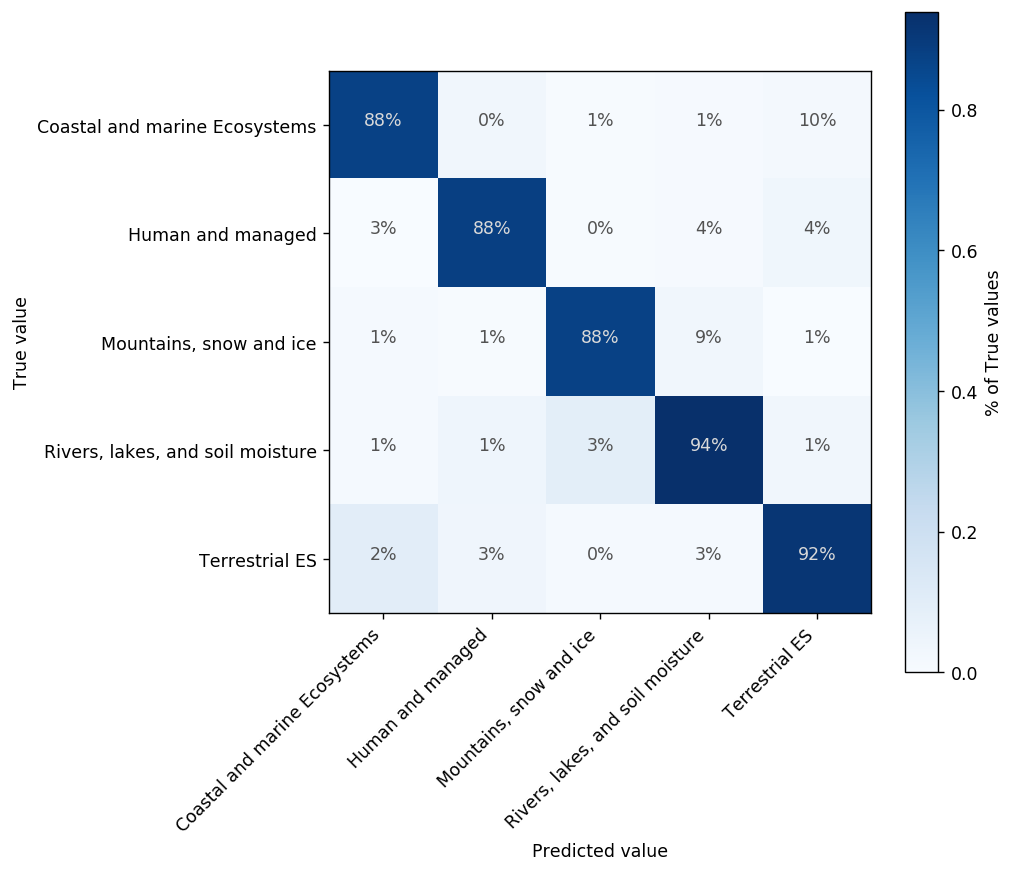

In [35]:
classes = broad_cats
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[broad_cats])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int).T

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

plt.savefig('../plots/prediction_models/broad_category_confusion_recall.pdf')

## Subcategories

In [38]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
all_classes = []
i = 0
broad_cats = []
for c in cats:
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname in df.columns and df[ecname].sum()>=5:
            all_classes.append(ecname)
            i+=1
    bc["end"] = i
    bc["size"] = i-bc["start"]
    broad_cats.append(bc)
            
print(len(all_classes))
broad_cats

50


[{'end': 10, 'name': 'Physical systems', 'size': 10, 'start': 0},
 {'end': 14, 'name': 'Mountains, snow and ice', 'size': 4, 'start': 10},
 {'end': 22,
  'name': 'Rivers, lakes, and soil moisture',
  'size': 8,
  'start': 14},
 {'end': 30, 'name': 'Coastal and marine Ecosystems', 'size': 8, 'start': 22},
 {'end': 39, 'name': 'Terrestrial ES', 'size': 9, 'start': 30},
 {'end': 50, 'name': 'Human and managed', 'size': 11, 'start': 39}]

In [42]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


new_rel_index = physical_index.intersection(rel_index)


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[all_classes])
print(y.shape)

multimodels = [
    {
       'title': 'One vs rest SVC balanced rbf', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
    },   
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },  
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_all_classes, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=5, classes=all_classes, df = df)


(2544, 50)
1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

5


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

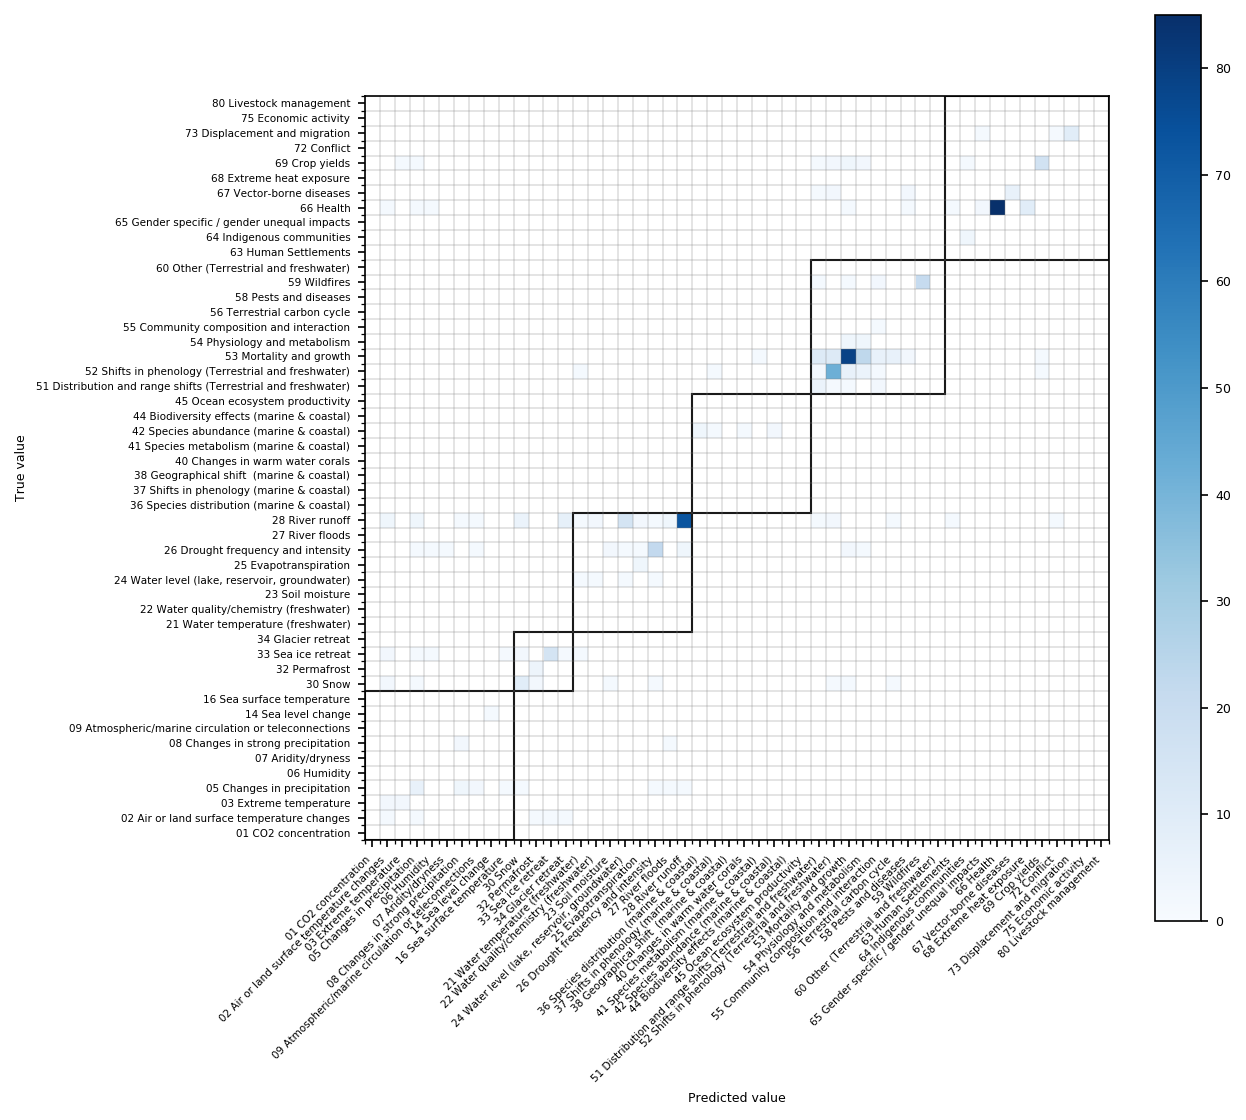

In [49]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

cols = [f"{c} - k_prediction_binary" for c in all_classes]
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols),len(cols)),dtype=float).T

for j, c in enumerate(all_classes):
    for k, c in enumerate(all_classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n


def plot_confusion_matrix(cm, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[j,k]
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color)

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_ylabel("True value", fontsize=6)
    ax.set_xlabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax)
    cbar.ax.tick_params(labelsize=6)
    
    if norm ==1:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    
plot_confusion_matrix(confusion_matrix,broad_cats=broad_cats)

plt.savefig(f'../plots/prediction_models/confusion_all_classes.pdf',bbox_inches="tight")


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


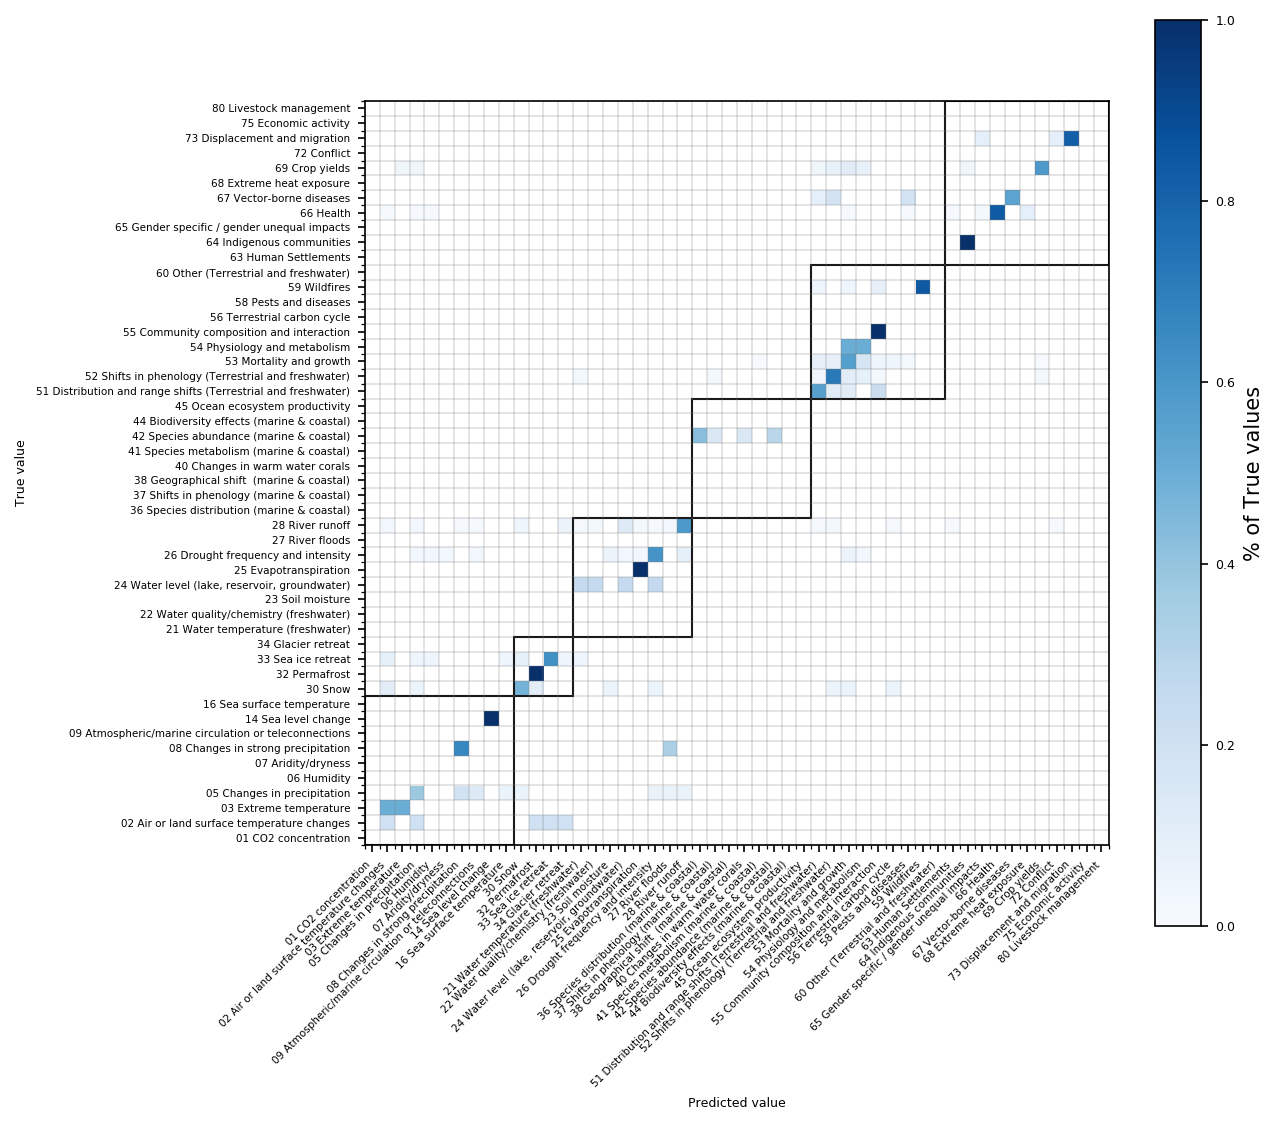

In [50]:
fig, ax = plt.subplots(figsize=(8,8),dpi=150)
plot_confusion_matrix(confusion_matrix,norm=1,broad_cats=broad_cats)
plt.savefig(f'../plots/prediction_models/confusion_all_classes_recall.pdf',bbox_inches="tight")

## Attribution prediction

In [14]:
df['2 - Trend or climate change attribution'] = 0
df.loc[
    (df['2 - 2.2 Trend attribution']==1) | (df['2 - 2.1. Climate change attribution']==1),
    '2 - Trend or climate change attribution'
] = 1

attribution_classes =  [
 '2 - Trend or climate change attribution',
 '2 - 2.4. Sensitivity',
 '2 - 2.5. Detection of a regional climate trend (no attribution)'
]

y = np.matrix(df[attribution_classes])


new_rel_index = physical_index.intersection(rel_index)
print(new_rel_index)
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]


attribution_models, attribution_metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=6, classes=attribution_classes, df =df)


Int64Index([   1,    2,    3,    7,   14,   24,   26,   31,   32,   33,
            ...
            2511, 2519, 2521, 2525, 2526, 2528, 2534, 2535, 2538, 2543],
           dtype='int64', length=868)
(2544, 3)
1
2
3
4
5
6


e
p
2 - Trend or climate change attribution
r
2 - Trend or climate change attribution
p
2 - 2.4. Sensitivity
r
2 - 2.4. Sensitivity
p
2 - 2.5. Detection of a regional climate trend (no attribution)
r
2 - 2.5. Detection of a regional climate trend (no attribution)


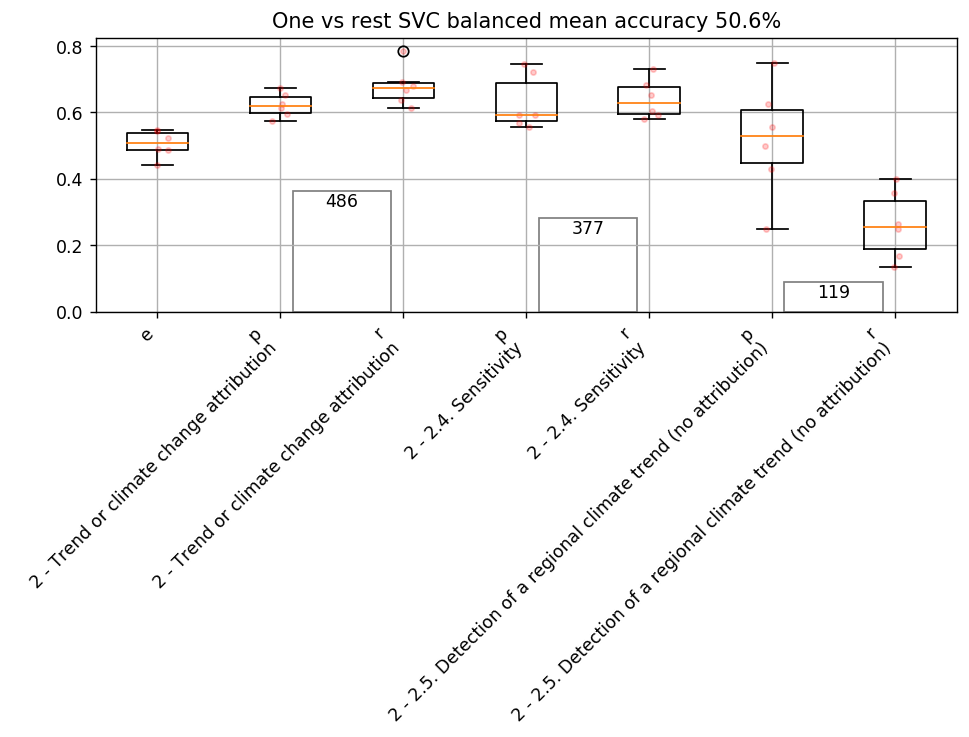

In [15]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(attribution_models, attribution_metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(attribution_metrics):
    print(m)
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x for x in attribution_metrics], rotation=45, ha="right")
plt.show()

['2 - Trend or climate change attribution', '2 - 2.4. Sensitivity', '2 - 2.5. Detection of a regional climate trend (no attribution)']


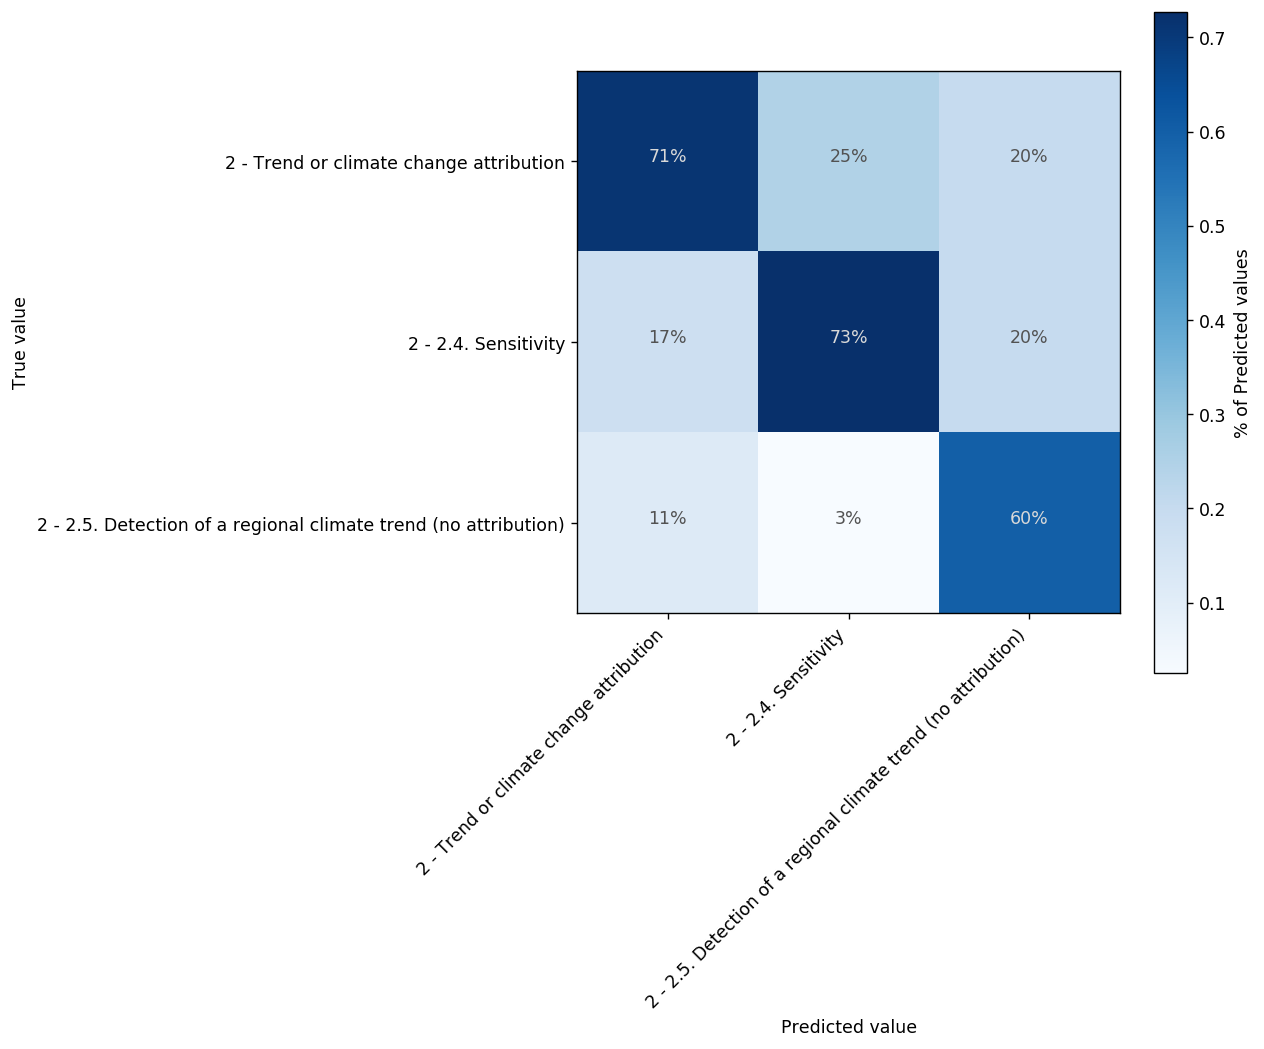

In [66]:
classes = attribution_classes
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[attribution_classes])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
#confusion_matrix = confusion_matrix.T

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1,keepdims=True)

confusion_matrix = confusion_matrix.T

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[k,j]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[k,j]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of Predicted values")

plt.savefig('../plots/prediction_models/attribution_category_confusion_precision.pdf')

In [60]:
confusion_matrix

array([[0.71139241, 0.24723247, 0.2       ],
       [0.17468354, 0.72693727, 0.2       ],
       [0.11392405, 0.02583026, 0.6       ]])

In [14]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

df['6 - Other'] = 0
df.loc[
    (df['6 - Temperature']==0) & 
    (df['6 - Precipitation']==0),
    '6 - Other'
] = 1

new_rel_index = physical_index.intersection(rel_index)

driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    '6 - Other'
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

In [20]:
classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

import scoping.utils.learning_utils as lu

from importlib import reload  
#reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
#     {
#        'title': 'One vs rest SVC balanced rbf', 
#        'model': OneVsRestClassifier(SVC(kernel='rbf', class_weight="balanced", probability=True))
#     },
    {
        'title': 'One vs rest SVC balanced lin', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
#     {
#         'title': 'One vs rest SVC balanced lin c10', 
#         'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
#     },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=6, classes=classes, df = df)

(2312, 3)
1
2
3
4
5
6


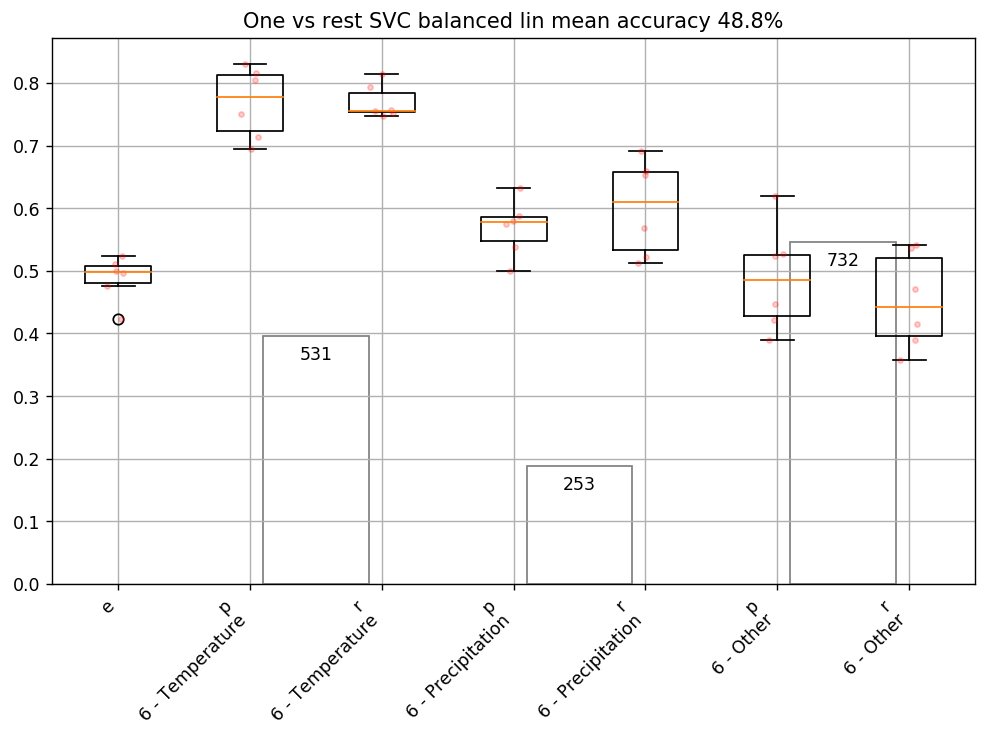

In [21]:
fig, axs = plt.subplots(len(multimodels_drivers_few), 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers_few, metrics, fig, axs)
for ax in axs:#ax = axs[0]
    for i,m in enumerate(metrics):
        if len(m)>2:
            v,c = m.split('\n')
            s = df.loc[rel_index,c].sum()/len(rel_index)
            if v=="p":
                ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
                ax.bar(i+1.5,s,color="none",edgecolor="grey")

    ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

['6 - Temperature', '6 - Precipitation', '6 - Other']


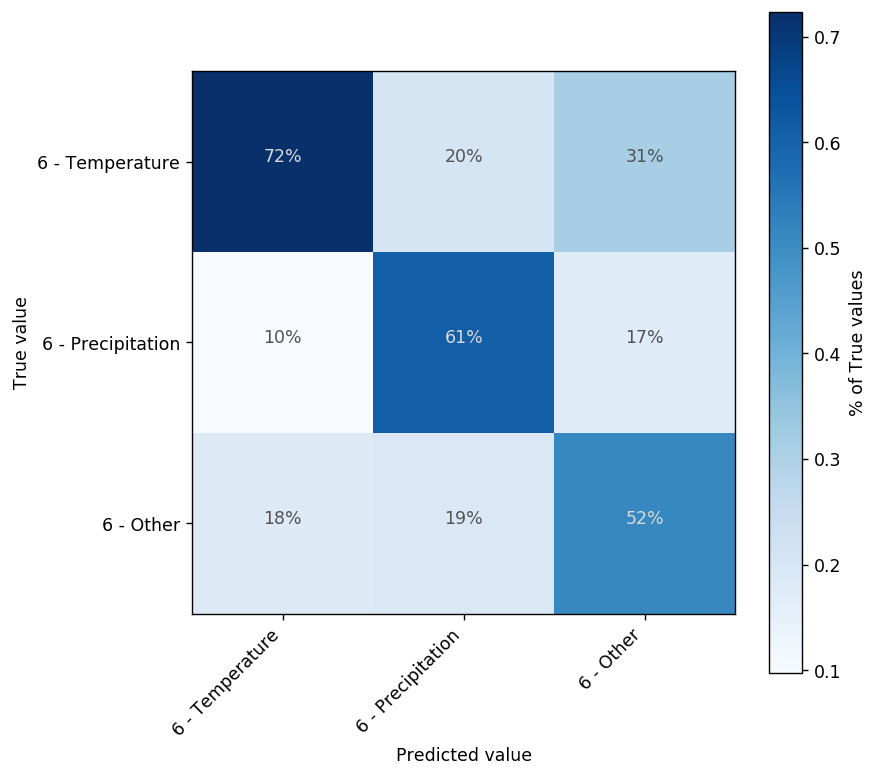

In [23]:
classes = driver_selection
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[driver_selection])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
#confusion_matrix = confusion_matrix.T

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1,keepdims=True)

confusion_matrix = confusion_matrix.T

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[k,j]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

plt.savefig('../plots/prediction_models/driver_category_confusion_recall.pdf')